In [71]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy import constants as const
from astropy import units as u
from scipy.interpolate import griddata, RegularGridInterpolator
from scipy.integrate import cumtrapz
from tqdm import tqdm

from lmfit import Model
from functions import getGridCell, getVar, remove_disc, calc_streamline

In [73]:
os.chdir('../data/')

rscale = 10.0 * u.AU
mscale = 0.7 * u.solMass
vscale = np.sqrt(const.G*mscale/rscale)/2.0/np.pi
rhoscale = mscale/rscale**3

i = 600
output = 'data.0710.dbl.h5'
xcell,ycell,zcell = ((getGridCell(filename=output)) * rscale).to(u.cm)

r = np.sqrt(xcell**2+ycell**2.+zcell**2)
th = np.arccos(ycell/r)

DIMT2 = xcell.shape[0]
DIMR2 = xcell.shape[1]

mu = 1.37125

X    = xcell.value
Z    = ycell.value

In [74]:
D    = ((getVar(output, i, 'rho') * rhoscale).to(u.g/u.cm**3)).value
vr   = ((getVar(output, i, 'vx1') * vscale).to(u.cm/u.s)).value
vth  = ((getVar(output, i, 'vx2') * vscale).to(u.cm/u.s)).value
vph  = ((getVar(output, i, 'vx3') * vscale).to(u.cm/u.s)).value
Pr   = ((getVar(output, i, 'prs') * vscale**2*rhoscale).to(u.barye)).value
Cd   = getVar(output, i, 'cd')
Td   = getVar(output, i, 'Tdust')

D = D*u.g/u.cm**3
Pr = Pr*u.barye

T    = ((Pr*mu*const.m_p)/(const.k_B*D)).to(u.K).value
vx = vr*np.sin(th) + vth*np.cos(th)
vz = vr*np.cos(th) - vth*np.sin(th)

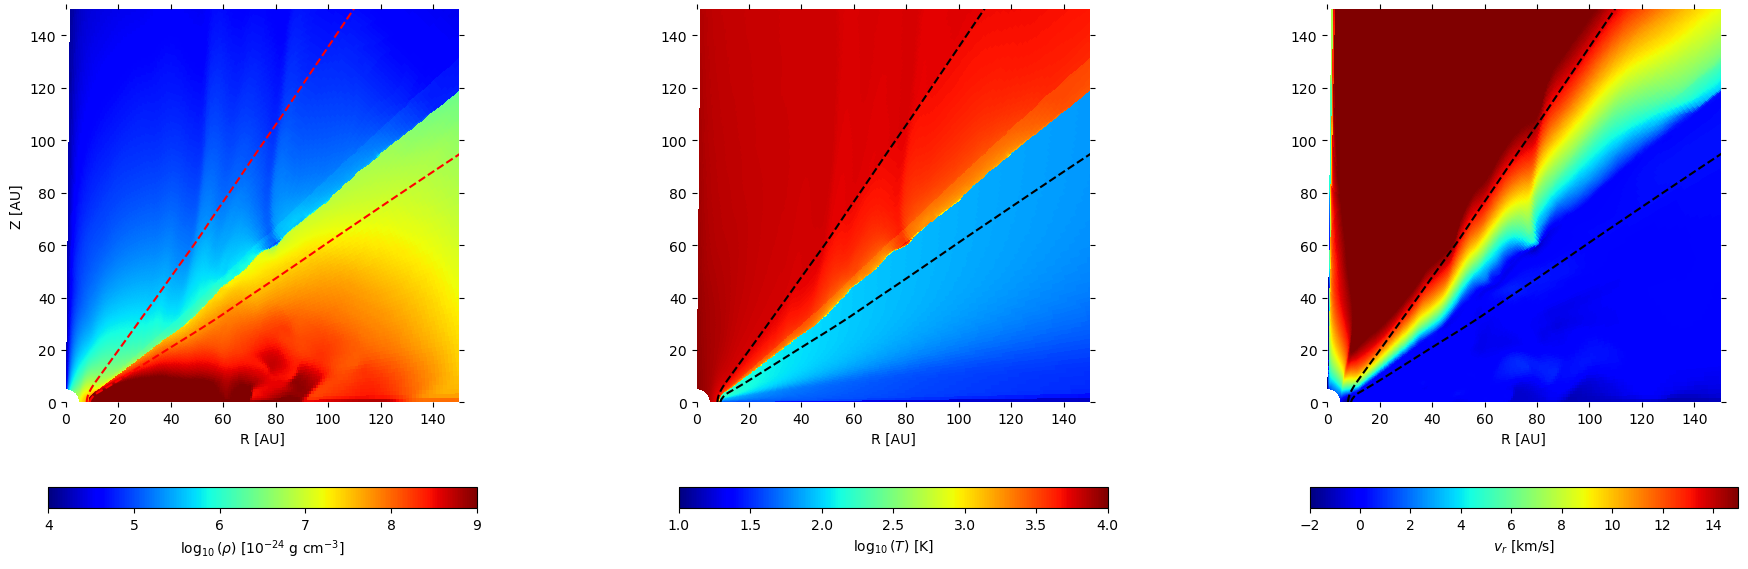

In [75]:
# width as measured in inkscape
width = 20#6.974
height = 6#5.231

fig , ax  = plt.subplots(1,3,sharey=False,sharex=False)
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)

for i in range(3):
    ax[i].set_xlim(0,150)
    ax[i].set_ylim(0,150)
    ax[i].set_aspect('equal')
    ax[i].set_xlabel('R [AU]')
    ax[i].set_ylabel('Z [AU]')
    if (i==0):
        valmin = 4
        valmax = 9
        quantity = D.value
        #quantity = (np.where(Cd<5.e20,quantity,np.nan))
        labelplot = '$\log_{10}(\\rho$) [$10^{-24}$ g cm$^{-3}$]'
        plot = ax[i].pcolormesh((X*u.cm).to(u.AU).value,(Z*u.cm).to(u.AU).value,np.log10(quantity*1.e24),
                                vmin=valmin,vmax=valmax,cmap=plt.cm.jet)
        vals = [5.e20,2.e22]
        contours1 = ax[i].contour((X*u.cm).to(u.AU).value,(Z*u.cm).to(u.AU).value,Cd, vals, 
                                  linestyles = 'dashed', colors='red')

    if (i==1):
        valmin = 1
        valmax = 4
        quantity = T
        #quantity = (np.where(Cd<5.e20,quantity,np.nan))
        labelplot = '$\log_{10}(T)$ [K]'
        ax[i].set_ylabel("")
        plot = ax[i].pcolormesh((X*u.cm).to(u.AU).value,(Z*u.cm).to(u.AU).value,np.log10(quantity),
                                vmin=valmin,vmax=valmax,cmap=plt.cm.jet)
        vals = [5.e20,2.e22]
        contours1 = ax[i].contour((X*u.cm).to(u.AU).value,(Z*u.cm).to(u.AU).value,Cd, vals, 
                                  linestyles = 'dashed', colors='black')

    if (i==2):
        valmin = -2.
        valmax = 15.
        quantity = (vr*u.cm/u.s).to(u.km/u.s).value
        #quantity = (np.where(Cd<5.e20,quantity,np.nan))
        labelplot = '$v_r$ [km/s]'
        ax[i].set_ylabel("")
        plot = ax[i].pcolormesh((X*u.cm).to(u.AU).value,(Z*u.cm).to(u.AU).value,quantity,
                                vmin=valmin,vmax=valmax,cmap=plt.cm.jet)
        vals = [5.e20,2.e22]
        contours1 = ax[i].contour((X*u.cm).to(u.AU).value,(Z*u.cm).to(u.AU).value,
                                  Cd, vals, linestyles = 'dashed', colors='black')

    fig.colorbar(plot, ax=ax[i], orientation='horizontal', label=labelplot)
    ax[i].tick_params(top='off', bottom='off', left='on', right='off', labelleft='on', labelbottom='on')
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["left"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)

plt.tight_layout()
fig.set_size_inches(width, height)
fig.savefig('Fig0340.png',dpi=400)
plt.show()
plt.close(fig)

In [80]:
vx = vr*np.sin(th) + vth*np.cos(th)
vz = vr*np.cos(th) - vth*np.sin(th)
v2 = vx**2 + vz**2
var = T
init = 55
Dnew,   Th_cut = remove_disc(var,D.value,init)
vrnew,  Th_cut = remove_disc(var,vr,init)
vthnew, Th_cut = remove_disc(var,vth,init)
vphnew, Th_cut = remove_disc(var,vph,init)
Tnew,   Th_cut = remove_disc(var,T,init)
vxnew,  Th_cut = remove_disc(var,vx,init)
vznew,  Th_cut = remove_disc(var,vz,init)
csnew,  Th_cut = remove_disc(var,Pr.value,init)

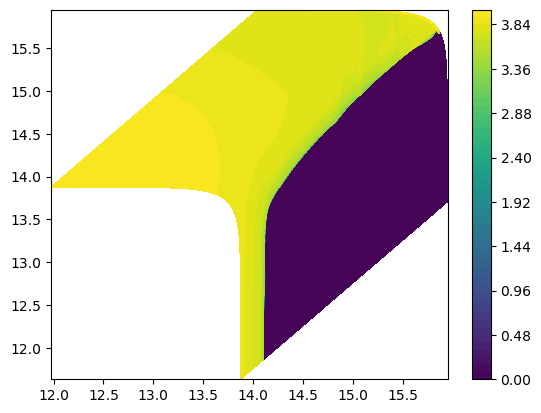

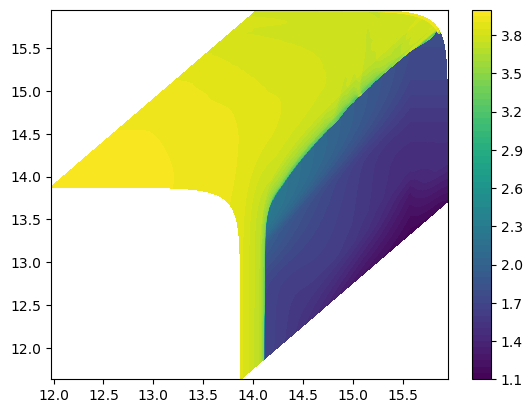

In [81]:
plt.contourf(np.log10(X),np.log10(Z),np.log10(abs(Tnew)),64)
plt.colorbar()
plt.figure()
plt.contourf(np.log10(X),np.log10(Z),np.log10(T),64)
plt.colorbar()

In [82]:
res = 4000
xcart=np.logspace(np.log10(1e12),np.log10(r.max().value*0.99999),res)
zcart=np.copy(xcart)
Xc,Zc=np.meshgrid(xcart,zcart)

In [83]:
Dc=griddata((X.reshape(DIMT2*DIMR2),Z.reshape(DIMT2*DIMR2)),Dnew.reshape(DIMT2*DIMR2),(Xc.reshape(res**2),Zc.reshape(res**2)),method='nearest',fill_value=0.)
Tc=griddata((X.reshape(DIMT2*DIMR2),Z.reshape(DIMT2*DIMR2)),Tnew.reshape(DIMT2*DIMR2),(Xc.reshape(res**2),Zc.reshape(res**2)),method='nearest',fill_value=0.)
vrc=griddata((X.reshape(DIMT2*DIMR2),Z.reshape(DIMT2*DIMR2)),vrnew.reshape(DIMT2*DIMR2),(Xc.reshape(res**2),Zc.reshape(res**2)),method='nearest',fill_value=0.)
vthc=griddata((X.reshape(DIMT2*DIMR2),Z.reshape(DIMT2*DIMR2)),vthnew.reshape(DIMT2*DIMR2),(Xc.reshape(res**2),Zc.reshape(res**2)),method='nearest',fill_value=0.)
vphic=griddata((X.reshape(DIMT2*DIMR2),Z.reshape(DIMT2*DIMR2)),vphnew.reshape(DIMT2*DIMR2),(Xc.reshape(res**2),Zc.reshape(res**2)),method='nearest',fill_value=0.)
vxc=griddata((X.reshape(DIMT2*DIMR2),Z.reshape(DIMT2*DIMR2)),vxnew.reshape(DIMT2*DIMR2),(Xc.reshape(res**2),Zc.reshape(res**2)),method='nearest',fill_value=0.)
vzc=griddata((X.reshape(DIMT2*DIMR2),Z.reshape(DIMT2*DIMR2)),vznew.reshape(DIMT2*DIMR2),(Xc.reshape(res**2),Zc.reshape(res**2)),method='nearest',fill_value=0.)
csc=griddata((X.reshape(DIMT2*DIMR2),Z.reshape(DIMT2*DIMR2)),csnew.reshape(DIMT2*DIMR2),(Xc.reshape(res**2),Zc.reshape(res**2)),method='nearest',fill_value=0.)

Dc=Dc.reshape(res,res)
Tc=Tc.reshape(res,res)
vrc=vrc.reshape(res,res)
vthc=vthc.reshape(res,res)
vphic=vphic.reshape(res,res)
vxc=vxc.reshape(res,res)
vzc=vzc.reshape(res,res)
csc=csc.reshape(res,res)

In [84]:
Func_Dc=RegularGridInterpolator((xcart,zcart),Dc.T,bounds_error=False,fill_value=-1.)
Func_vrc=RegularGridInterpolator((xcart,zcart),vrc.T,bounds_error=False,fill_value=-1.)
Func_vthc=RegularGridInterpolator((xcart,zcart),vthc.T,bounds_error=False,fill_value=-1.)
Func_vphc=RegularGridInterpolator((xcart,zcart),vphic.T,bounds_error=False,fill_value=-1.)
Func_vxc=RegularGridInterpolator((xcart,zcart),vxc.T,bounds_error=False,fill_value=-1.)
Func_vzc=RegularGridInterpolator((xcart,zcart),vzc.T,bounds_error=False,fill_value=-1.)
Func_csc=RegularGridInterpolator((xcart,zcart),csc.T,bounds_error=False,fill_value=-1.)

0.012449999846905925 rad 0.8987500007517303 rad 0.012450000337182375 rad


(0.0, 400.0)

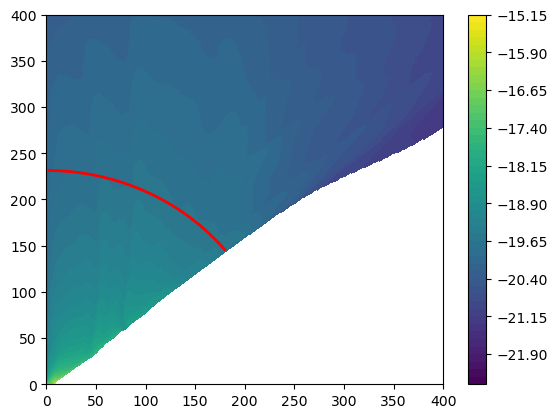

In [85]:
fin = DIMR2 - 100

r_surf=r[DIMT2-1][fin]
th_final=th[Th_cut[fin]-1,fin]
th_surf=np.linspace(th[0,fin]*1.01,0.99*th_final,fin)
print(th[0,100],th_final,th[0,0])
x_surf=r_surf*np.sin(th_surf)
z_surf=r_surf*np.cos(th_surf)

plt.contourf(Xc*u.cm.to(u.AU),Zc*u.cm.to(u.AU),np.log10(Dc),64)
plt.colorbar()
plt.plot(x_surf*u.cm.to(u.AU),z_surf*u.cm.to(u.AU),'r',lw=2)
plt.xlim(0,400)
plt.ylim(0,400)

In [86]:
Rstart=[]

xsu = np.zeros(np.size(th_surf))
zsu = np.zeros(np.size(th_surf))
thsu = np.zeros(np.size(th_surf))
rsu = np.zeros(np.size(th_surf))
sonxar = []
sonzar = []
Tval = []
densval = []
vphival = []

j = 0
for i in tqdm(range(np.size(th_surf))):
    rmax = r[DIMT2-1]
    xs,zs,sonx,sonz,Ts,rhos,vphis = calc_streamline(rmax.value,x_surf[i].value,z_surf[i].value,Func_vxc,Func_vzc,Func_vphc,Func_csc,Func_Dc)
    if(not(np.isnan(xs[-1])) and not(np.isnan(zs[-1])) and not(zs[-1]<1.)):
        xsu[j] = x_surf[i].value
        zsu[j] = z_surf[i].value
        thsu[j] = th_surf[i].value
        rsu[j] = r_surf.value
        if Ts>0:
            Rstart.append(xs[-1])
            sonxar.append(sonx)
            sonzar.append(sonz)
            Tval.append(Ts)
            densval.append(rhos)
            vphival.append(vphis)
            j = j+1

100%|██████████| 400/400 [03:41<00:00,  1.81it/s]


Total Mass-loss in Msun/year: 3.070302684472159e-08 solMass / yr
3.070302684472159e-08 solMass / yr


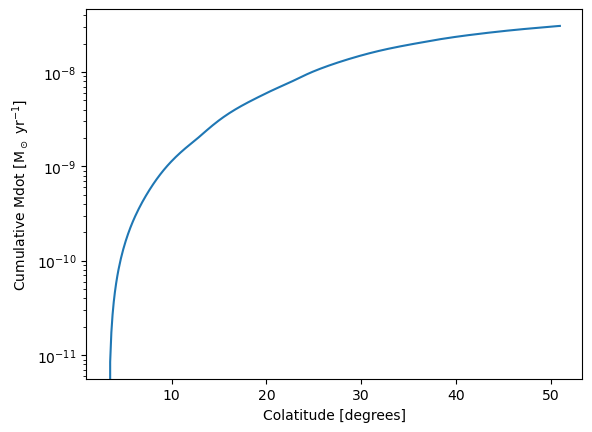

In [87]:
sigma_dot_theta=Func_Dc((xsu,zsu))*Func_vrc((xsu,zsu))
p = 0
for i in range(j):
    if(sigma_dot_theta[i] < 0. or sigma_dot_theta[i] > 1.e-10):
        p = p+1
integrand=4.*np.pi*np.sin(thsu)*rsu**2.*sigma_dot_theta

j = j-p

Mdot_cumlative_theta=cumtrapz(integrand,thsu,initial=0.)

plt.semilogy(thsu[0:j]/np.pi*180.,(Mdot_cumlative_theta[0:j]*u.g/u.s).to(u.M_sun/u.yr))
plt.xlabel(r'Colatitude [degrees]')
plt.ylabel(r'Cumulative Mdot [M$_\odot$ yr$^{-1}$]')
print('Total Mass-loss in Msun/year:', (Mdot_cumlative_theta[j-1]*u.g/u.s).to(u.M_sun/u.yr))
print((Mdot_cumlative_theta.max()*u.g/u.s).to(u.M_sun/u.yr))

zsh:1: no matches found: stream*.dat
/Users/giovanni/Documents/Papers/disc-photoevaporation-gaps/data


100%|██████████| 379/379 [00:13<00:00, 28.75it/s]


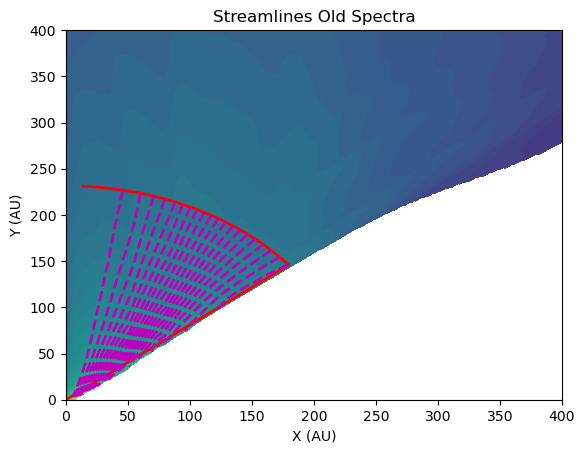

In [88]:
!rm stream*.dat
!pwd
plt.figure()
plt.contourf(Xc*u.cm.to(u.AU),Zc*u.cm.to(u.AU),np.log10(Dc),64)
#plt.colorbar(label=r'density (g/cm^3)')
plt.title(r'Streamlines Old Spectra')
plt.xlim(0,400)
plt.ylim(0,400)
plt.xlabel(r'X (AU)')
plt.ylabel(r'Y (AU)')
#plt.cblabel('$$\Sigma$$ (g/cm^2)')
plt.plot(xsu*u.cm.to(u.AU),zsu*u.cm.to(u.AU),'r',lw=2)
k = 1
for i in tqdm(range(j)):
    if(Mdot_cumlative_theta[i]/Mdot_cumlative_theta[j-1]>=(0.0498*k)):
        rmax = r[DIMT2-1]
        #xs,zs,ar,br = calc_streamline2(rmax.value,xsu[i],zsu[i],Func_vxc,Func_vzc,Func_csc,Func_Dc)
        xs,zs,ar,br,Ts,rhos,vphis = calc_streamline(rmax.value,xsu[i],zsu[i],Func_vxc,Func_vzc,Func_vphc,Func_csc,Func_Dc)
        with open('stream'+str(k)+'.dat', 'a') as f:
            for s,t in zip(xs,zs):
                f.write("%s %s\n" % (s,t))
        plt.plot((xs*u.cm).to(u.AU).value,(zs*u.cm).to(u.AU).value,'m--',lw=2)
        k = k+1
plt.savefig('streamlines0340.png')
plt.close(fig)

61.259619314553674
3.070302684472159e-08 solMass / yr
307
[[Model]]
    Model(fitFunc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 307
    # variables        = 6
    chi-square         = 0.86101217
    reduced chi-square = 0.00286051
    Akaike info crit   = -1792.08378
    Bayesian info crit = -1769.72269
    R-squared          = 0.97911459
[[Variables]]
    c0:  12.2521105 +/- 4.83142311 (39.43%) (init = 1)
    c1: -60.3559384 +/- 17.9743368 (29.78%) (init = 1)
    c2:  105.544587 +/- 26.1880976 (24.81%) (init = 1)
    c3: -84.1592607 +/- 18.6761465 (22.19%) (init = 1)
    c4:  31.6580125 +/- 6.52244325 (20.60%) (init = 1)
    c5: -4.55560486 +/- 0.89319462 (19.61%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(c4, c5) = -0.9991
    C(c3, c4) = -0.9990
    C(c2, c3) = -0.9989
    C(c1, c2) = -0.9988
    C(c0, c1) = -0.9988
    C(c3, c5) = +0.9964
    C(c2, c4) = +0.9959
    C(c1, c3) = +0.9955
    

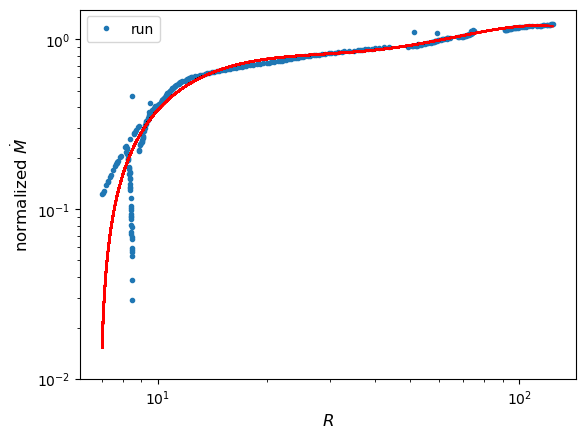

<Figure size 640x480 with 0 Axes>

In [168]:
radii = []
acc = []
addit = 0
t = 0
for i in range(j):
    spa = Rstart[i]*u.cm.to(u.AU)
    spb = Mdot_cumlative_theta[i]
    #if(spa<129.5):
    if(spa<7):
        pass
        #radii.append(spa)
        #acc.append(0.)
        #t = t+1
    elif(spa<150):
        radii.append(spa)
        acc.append(spb)
        t = t+1

print(Rstart[t-1]*u.cm.to(u.AU))
#for i in range(addit):
#    spa = min(Rstart)*u.cm.to(u.AU) - 0.1*i
#    spb = 0.
#    radii.append(spa)
#    acc.append(spb)
for i in range(addit):
    spa = Rstart[t-1]*u.cm.to(u.AU) + 1*i + 80
    spb = Mdot_cumlative_theta[t-1]*1.3
    radii.append(spa)
    acc.append(spb)

acc = acc/Mdot_cumlative_theta[t-1]
print((Mdot_cumlative_theta[j-1]*u.g/u.s).to(u.M_sun/u.yr))
Mdarray = np.column_stack((radii, acc))
print(t)
bfg = Mdarray[Mdarray[:,0].argsort()]
#bfg[0,1] = 0.

def fitFunc(x, c0, c1, c2, c3, c4, c5):
    v = np.log10(x)
    #return 1.0 / pow(a + b * np.exp(c*x),d) + Offset
    return c5*v**5 + c4*v**4 + c3*v**3 + c2*v**2 + c1*v + c0
def derfitFunc(x, c1, c2, c3, c4, c5):
    v = np.log10(x)
    return 5*c5*v**4 + 4*c4*v**3 + 3*c3*v**2 + 2*c2*v + c1

gmod = Model(fitFunc)

c0 = 1
c1 = 1
c2 = 1
c3 = 1
c4 = 1
c5 = 1
c6 = 1
c7 = 1
c8 = 1

#result = gmod.fit(bfg[:,1], x=bfg[:,0], c0=c0, c1=c1, c2=c2, c3=c3, c4=c4, c5=c5, c6=c6, c7=c7, c8=c8)
result = gmod.fit(bfg[:,1], x=bfg[:,0], c0=c0, c1=c1, c2=c2, c3=c3, c4=c4, c5=c5)

x1 = np.linspace(bfg[0,0],bfg[:,0],2000)
y = fitFunc(x1, result.best_values['c0'], result.best_values['c1'], result.best_values['c2'],
            result.best_values['c3'], result.best_values['c4'], result.best_values['c5']) 
#            result.best_values['c6'], result.best_values['c7'], result.best_values['c8'])

plt.loglog(bfg[:,0], bfg[:,1], '.', label='run')

plt.xlabel(r"$R$", size=12, color='black')
plt.ylabel(r"normalized $\dot{M}$", size=12, color='black')
plt.legend()
print(result.fit_report())
#plt.xlim(bfg[0,0],bfg[-1,0])
#plt.xlim(0,100)
plt.ylim(1.e-2,1.5)
#plt.plot(bfg[0:j+addit,0], result.init_fit, 'k--')
plt.semilogx(x1, y, 'r-')
#plt.plot(x,y2, 'g-')
#plt.grid()
plt.show()
plt.savefig('cumdot0340.pdf',dpi=400)
#np.save("data1040au",bfg)

4.386146692103084


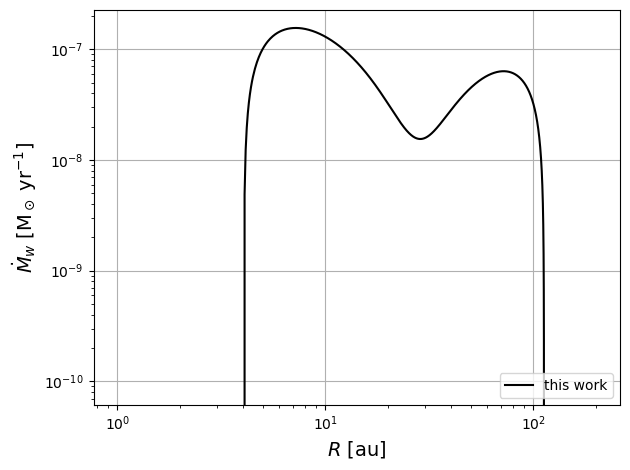

In [169]:
fig, ax = plt.subplots(ncols=1, nrows=1)

Rau=np.linspace(Rstart[0]*u.cm.to(u.AU),Rstart[-1]*u.cm.to(u.AU),1000)
lgR=np.log10(Rau)

Mdot = 0.5*2.1335923027567715e-08

x = np.linspace(1,200,4000)
cax = ax.loglog(x,derfitFunc(x, result.best_values['c1'], result.best_values['c2'], result.best_values['c3'],
                    result.best_values['c4'], result.best_values['c5'])* 
                    #result.best_values['c6'], result.best_values['c7'], result.best_values['c8'])
                    (Mdot_cumlative_theta[j-1]*u.g/u.s).to(u.M_sun/u.yr)*2.,'k-',label='this work')

ax.set_xlabel(r"$R$ [au]", size=14, color='black')
ax.set_ylabel(r'$\dot{M}_w$ [M$_\odot$ yr$^{-1}$]', size=14, color='black')
ax.legend(loc=4)
plt.tight_layout()
#rasterize_and_save('O10comp.pdf', cax, fig=fig, dpi=400)
plt.savefig('sigmadot0340.pdf',dpi=400)
print((Mdot_cumlative_theta[j-1]*u.g/u.s).to(u.M_sun/u.yr).value*2./1.4e-8)
plt.grid()
#plt.xlim(5,200)
plt.show()
plt.close(fig)